
Dataset Preview:
  Country  Year  Avg_Temperature(°C)  Rainfall(mm)  Malaria_Cases_per_1000
0   Kenya  2010                22.72        1336.0                   290.1
1   Kenya  2011                22.18        1407.0                   301.6
2   Kenya  2012                22.83        1322.5                   314.9
3   Kenya  2013                22.95        1341.7                   293.5
4   Kenya  2014                22.31        1350.9                   297.7

Summary:
              Year  Avg_Temperature(°C)  Rainfall(mm)  Malaria_Cases_per_1000
count   130.000000           130.000000    130.000000              130.000000
mean   2016.000000            23.335846   1171.308462              242.823846
std       3.756132             2.347594    143.374911               45.816503
min    2010.000000            19.750000    928.200000              166.600000
25%    2013.000000            20.790000   1029.975000              195.925000
50%    2016.000000            23.220000   1182.400000 

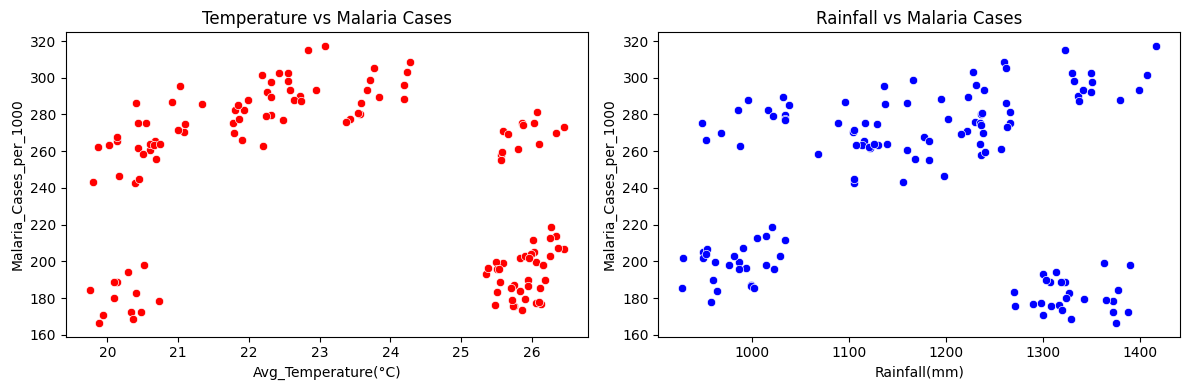


Model Comparison:
                         MAE        R²
Linear Regression  36.036267  0.130806
Random Forest       9.298115  0.911092
Gradient Boosting   6.460092  0.958684

Model saved!


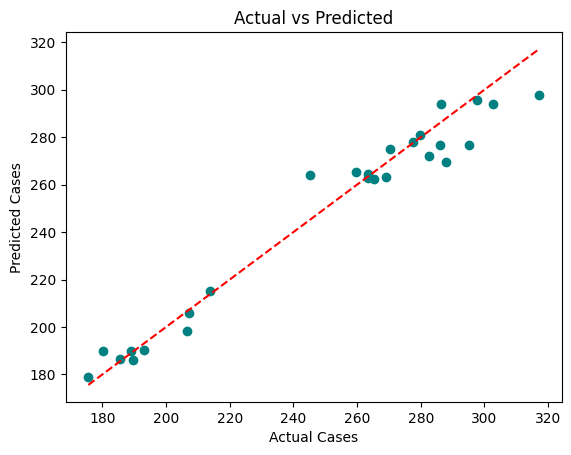


Fetching Nairobi weather...

Predicted malaria cases per 1000: 256.93

✅ Done!


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [2]:
# 🦟 Malaria Prediction - SDG 3

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# --- Load dataset ---
df = pd.read_csv("malaria_data.csv")
print("\nDataset Preview:")
print(df.head())

print("\nSummary:")
print(df.describe())

# --- Visualize ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Avg_Temperature(°C)', y='Malaria_Cases_per_1000', data=df, color='red')
plt.title("Temperature vs Malaria Cases")

plt.subplot(1, 2, 2)
sns.scatterplot(x='Rainfall(mm)', y='Malaria_Cases_per_1000', data=df, color='blue')
plt.title("Rainfall vs Malaria Cases")

plt.tight_layout()
plt.show()

# --- Prepare data ---
X = df[['Avg_Temperature(°C)', 'Rainfall(mm)']]
y = df['Malaria_Cases_per_1000']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Compare models ---
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "R²": r2}

results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# --- Save best model ---
best_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
joblib.dump(best_model, "malaria_model.pkl")
print("\nModel saved!")

# --- Visualize predictions ---
y_pred = best_model.predict(X_test)
plt.scatter(y_test, y_pred, color='teal')
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# --- Real-time prediction ---
def get_weather(lat, lon, days=30):
    end_date = date.today()
    start_date = end_date - timedelta(days=days)
    
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date.isoformat(),
        "end_date": end_date.isoformat(),
        "daily": ["temperature_2m_mean", "precipitation_sum"],
        "timezone": "Africa/Nairobi"
    }
    
    response = requests.get(url, params=params)
    return response.json()

# Predict for Nairobi
print("\nFetching Nairobi weather...")
weather_data = get_weather(-1.286389, 36.817223)

temps = weather_data['daily']['temperature_2m_mean']
rain = weather_data['daily']['precipitation_sum']

avg_temp = sum(temps) / len(temps)
avg_rain = sum(rain) / len(rain)

loaded_model = joblib.load("malaria_model.pkl")
predicted_cases = loaded_model.predict([[avg_temp, avg_rain]])

print(f"\nPredicted malaria cases per 1000: {predicted_cases[0]:.2f}")
print("\n✅ Done!")